### 鑽石預測 資料來源:kaggle

| Paper名稱              | 出版處 | 發表年份 | 資料清洗                    | 去離群值 | 處理類別型欄位 | 標準化 | 特徵選擇 | 使用模型                                                         | 評估指標                     |
|------------------------|--------|----------|-----------------------------|----------|----------------|--------|------------|------------------------------------------------------------------|------------------------------|
| 1. Comparative Analysis | IEEE   | 2021 年  | 無缺失值                    | x        | v              | v      | x          | Random Forest、ElasticNet、AdaBoost 等八種監督式模型            | RMSE, CV, R²                |
| 2. ML Techniques        | IEEE   | 2023 年  | 無缺失值                    | v        | v              | v      | x          | XGBoost、MLP、KNN 等八種監督式模型                              | MAE, MSE, RMSE, R²          |
| 3. LASSO & k-NN         | IEEE   | 2022 年  | 無缺失值，去除重複值        | x        | v              | v      | v          | k-NN 與 LASSO                                                   | RMSE, R²                    |


### 1.Comparative_Analysis_of_Supervised_Models_for_Diamond_Price_Prediction

<pre lang="markdown"> [讀取資料] --> [Label Encoding] --> [StandardScaler] --> [建立多個模型] </pre>

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold,StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

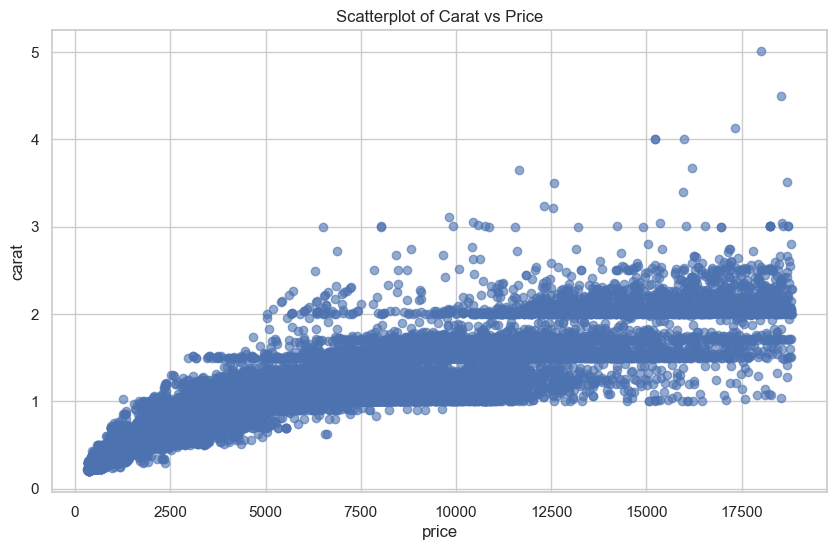

In [11]:
#  diamonds.csv
df = pd.read_csv("D:\\中興大學\期末報告\\diamonds.csv")
df = df.drop(columns=['Unnamed: 0'])
# price 對 carat 的散佈圖
plt.figure(figsize=(10, 6))
plt.scatter(df['price'], df['carat'], alpha=0.6)
plt.xlabel('price')
plt.ylabel('carat')
plt.title('Scatterplot of Carat vs Price')
plt.grid(True)
plt.show()

*  整體趨勢是：克拉數越大，價格越高。
*  但隨著克拉數增加，價格的波動也變大，顯示「價格波動性上升」的現象。

In [12]:
# 欄位名稱 和 資料型態
df.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

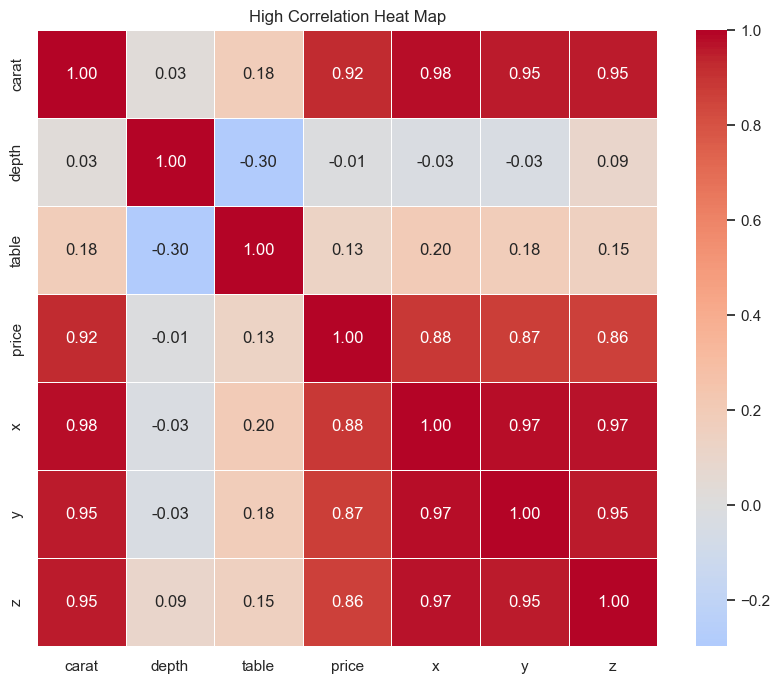

In [13]:
correlation_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, center=0)
plt.title("High Correlation Heat Map")
plt.show()

* carat 和 price 的相關係數約為 0.92，高度正相關。
* x, y, z（鑽石尺寸）也與 price 有高相關（都在 0.86 ~ 0.88 之間）。
* depth 和 table 的相關性則較弱。

In [14]:
df['carat_bin'] = pd.qcut(df['carat'], q=10, duplicates='drop', labels=False)

X = df.drop(columns=['price', 'carat_bin'])
y = df['price']
X_encoded = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=df['carat_bin'], random_state=42
)


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# 建立模型
model = LinearRegression()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    model, X_train, y_train,
    cv=skf.split(X_train, df.loc[X_train.index, 'carat_bin']),
    scoring=rmse_scorer
)

print("Cross-Validation RMSEs:", -cv_scores)
print("Average CV RMSE:", -cv_scores.mean())

Cross-Validation RMSEs: [1141.70158444 1109.57482471 1138.04115201 1132.16488035 1128.61005371]
Average CV RMSE: 1130.0184990434147


In [16]:
df = pd.read_csv("D:\\中興大學\\期末報告\\diamonds.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# 類別變數轉數字
label_encoders = {}
for col in ['cut', 'color', 'clarity']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# 特徵與目標
X = df.drop(columns=['price'])
y = df['price']

# 資料切分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 定義模型
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "Decision Tree": DecisionTreeRegressor(max_depth=10),
    "Linear Regression": LinearRegression(),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "Lasso Regression": Lasso(alpha=0.1),
    "AdaBoost": AdaBoostRegressor(n_estimators=50, random_state=42),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Ridge Regression": Ridge(alpha=1.0)
}

# 評估
results = []
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    accuracy = r2 * 100  

    cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())
    results.append([name, rmse, cv_rmse, accuracy])

df_results = pd.DataFrame(results, columns=["Model", "RMSE", "Cross-Validation RMSE", "Accuracy"])
df_results = df_results.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)
df_results

,Model,RMSE,Cross-Validation RMSE,Accuracy
0,Random Forest,569.237693,582.791666,97.961658
1,Decision Tree,630.164799,665.212760,97.501968
2,Gradient Boosting,655.694773,684.031070,97.295462
3,AdaBoost,1260.560387,1339.595915,90.004213
4,Ridge Regression,1351.262011,1355.212906,88.513999
5,Linear Regression,1351.263480,1355.234769,88.513974
6,Lasso Regression,1351.268941,1355.152417,88.513881
7,ElasticNet,1444.055914,1457.803767,86.882299


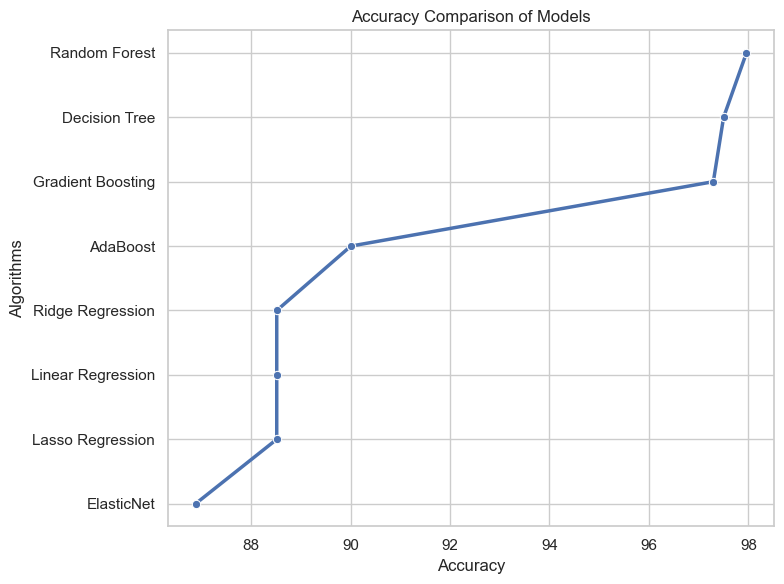

In [17]:
df_sorted = df_results.sort_values(by='Accuracy', ascending=False)

plt.figure(figsize=(8, 6))
sns.lineplot(x='Accuracy', y='Model', data=df_sorted, marker='o', linewidth=2.5)
plt.title("Accuracy Comparison of Models")
plt.xlabel("Accuracy")
plt.ylabel("Algorithms")
plt.grid(True)
plt.tight_layout()
plt.show()

#### 2.Diamond_Price_Prediction_using_Machine_Learning_Techniques

<pre lang="markdown"> [讀取資料集] --> [檢查/處理缺失值] --> [移除離群值 (IQR)] --> [Label Encoding] --> [特徵選擇] --> [建立多個模型] </pre>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

In [2]:
#  diamonds.csv
df = pd.read_csv("D:\\中興大學\期末報告\\diamonds.csv")
df = df.drop(columns=['Unnamed: 0'])
# 檢查缺失值
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [3]:
# 離群值
def mark_outliers_iqr(data, columns):
    outlier_flags = pd.DataFrame(False, index=data.index, columns=columns)
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outlier_flags[col] = (data[col] < lower) | (data[col] > upper)
    outlier_rows = outlier_flags.any(axis=1)
    return outlier_rows

# 數值欄位
numerical_features = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
outlier_mask = mark_outliers_iqr(df, numerical_features)
outliers = df[outlier_mask]

print(f"離群值筆數：{len(outliers)}筆，佔比：{(len(outliers)/len(df))*100:.2f}%")
outliers.head()

離群值筆數：6416筆，佔比：11.89%


,carat,cut,color,clarity,depth,table,price,x,y,z
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
8,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
24,0.31,Very Good,J,SI1,58.1,62.0,353,4.44,4.47,2.59
35,0.23,Good,F,VS1,58.2,59.0,402,4.06,4.08,2.37
42,0.26,Good,D,VS2,65.2,56.0,403,3.99,4.02,2.61


In [4]:
# 移除離群值
def remove_outliers_iqr(data, columns):
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        data = data[(data[col] >= lower) & (data[col] <= upper)]
    return data

df = remove_outliers_iqr(df, numerical_features)

# Step 3：Label Encoding
le = LabelEncoder()
for col in ['cut', 'color', 'clarity']:
    df[col] = le.fit_transform(df[col])

# market_demand 分群
df['market_demand'] = pd.qcut(df['price'], q=3, labels=['low', 'medium', 'high'])
df['market_demand'] = le.fit_transform(df['market_demand'])
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,market_demand
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43,1
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31,1
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63,1
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75,1
5,0.24,4,6,7,62.8,57.0,336,3.94,3.96,2.48,1


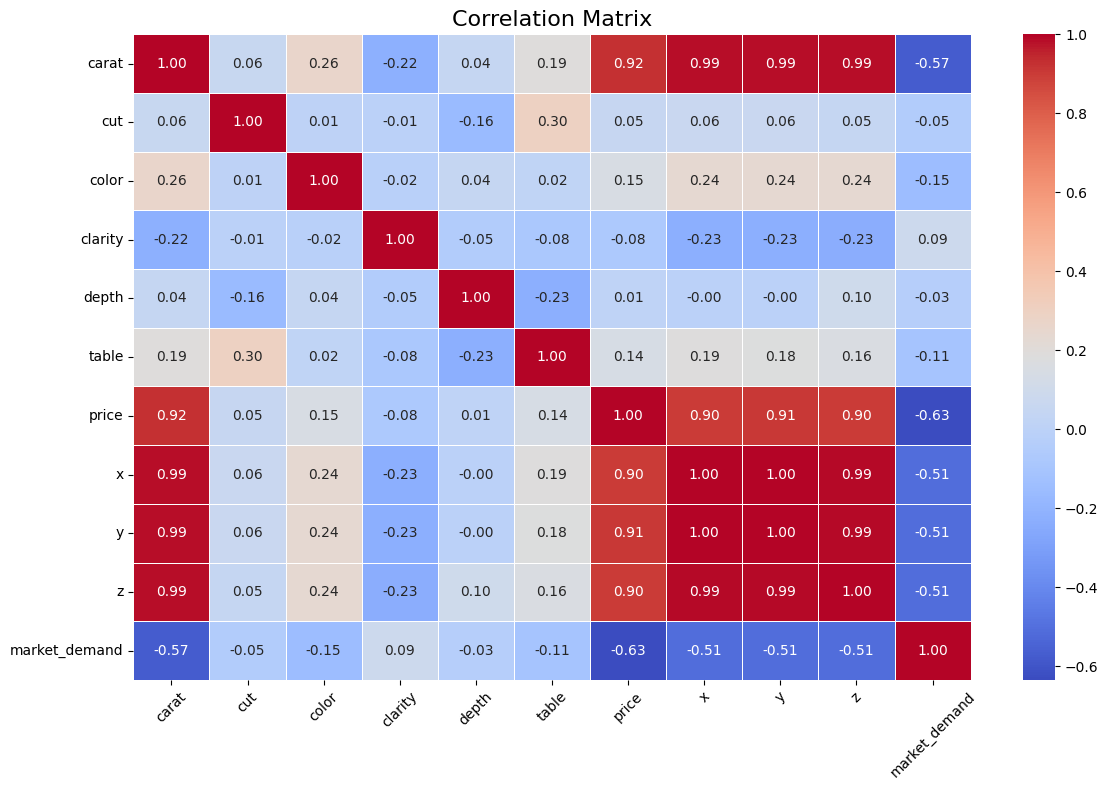

In [5]:
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [6]:
features  = ['carat', 'cut', 'clarity', 'color', 'x', 'y', 'z','depth','table']
X = df[features]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(n_estimators=100),
    "KNeighbors": KNeighborsRegressor(n_neighbors=5),
    "XGBRegressor": XGBRegressor(n_estimators=300),
    "ExtraTreeRegressor": ExtraTreesRegressor(n_estimators=100),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1),
    "MLP": MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500)
}


results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R Squared': r2
    })


results_df = pd.DataFrame(results).sort_index()
results_df

,Model,MAE,MSE,RMSE,R Squared
0,LinearRegression,567.916027,697003.796559,834.867532,0.896314
1,DecisionTree,259.120393,238556.832948,488.422801,0.964512
2,RandomForest,192.162892,123785.374497,351.831458,0.981586
3,KNeighbors,343.129666,327935.486541,572.656517,0.951217
4,XGBRegressor,192.134094,122166.640625,349.523448,0.981827
5,ExtraTreeRegressor,188.525790,119180.357145,345.225082,0.982271
6,GradientBoosting,223.726090,139723.044494,373.795458,0.979215
7,MLP,409.160588,439141.865100,662.677799,0.934674


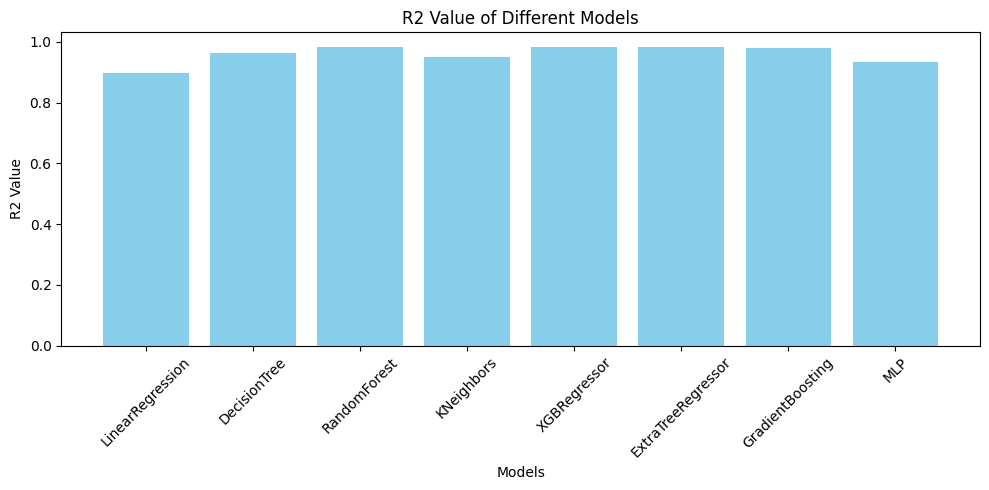

In [7]:
plt.figure(figsize=(10, 5))
plt.bar(results_df['Model'], results_df['R Squared'], color='skyblue')
plt.title('R2 Value of Different Models')
plt.xlabel('Models')
plt.ylabel('R2 Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

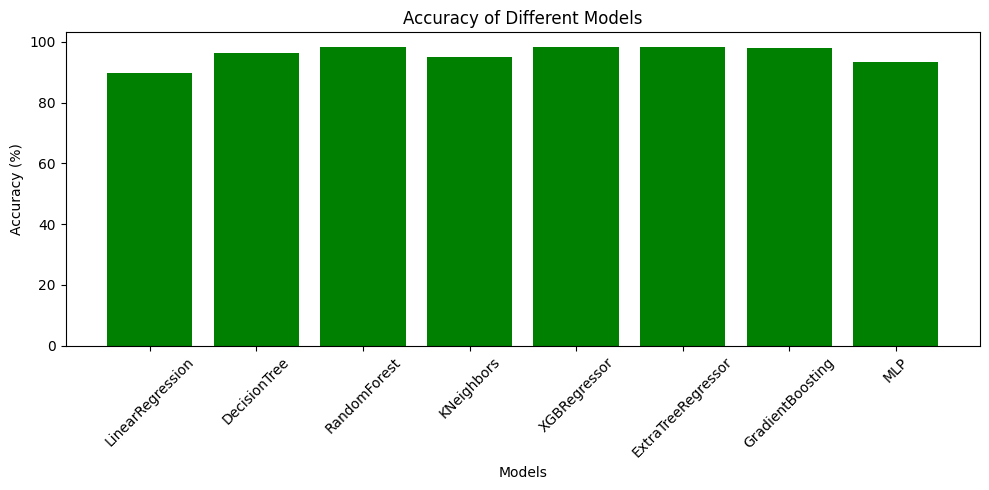

In [8]:
plt.figure(figsize=(10, 5))
accuracy = results_df['R Squared'] * 100
plt.bar(results_df['Model'], accuracy, color='green')
plt.title('Accuracy of Different Models')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 3.Least_Absolute_Shrinkage_and_Selection_Operator_LASSO_and_k-Nearest_Neighbors_k-NN_Algorithm_Analysis_Based_on_Feature_Selection_for_Diamond_Price_Prediction

<pre lang="markdown"> [讀取資料集] --> [檢查/處理缺失值] --> [Label Encoding] --> [特徵選擇] --> [k-NN 與 LASSO 模型評估] </pre>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso

In [ ]:
df = pd.read_csv("D:\\中興大學\\期末報告\\diamonds.csv")
df = df.drop(columns=['Unnamed: 0'])

# 資料清理
df = df.drop_duplicates().reset_index(drop=True)

# Label Encoding
label_encoders = {}
categorical_cols = ['cut', 'color', 'clarity']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


X = df.drop(columns=['price'])
y = df['price']

# 切分資料集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [20]:
# 特徵選擇_前四名
skb = SelectKBest(score_func=f_regression, k=4)
skb.fit(X, y)  

scores = skb.scores_
all_features = X.columns.values
sort_index = np.argsort(scores)[::-1] 

rank = 1
ranked_features = []

for x in sort_index[:4]: 
    print(f"{rank}. Score  {all_features[x]} is {scores[x]}")
    ranked_features.append(all_features[x])
    rank += 1

1. Score  carat is 303040.2851045828
2. Score  x is 193354.13157891255
3. Score  y is 160441.02626413837
4. Score  z is 154444.84396997257


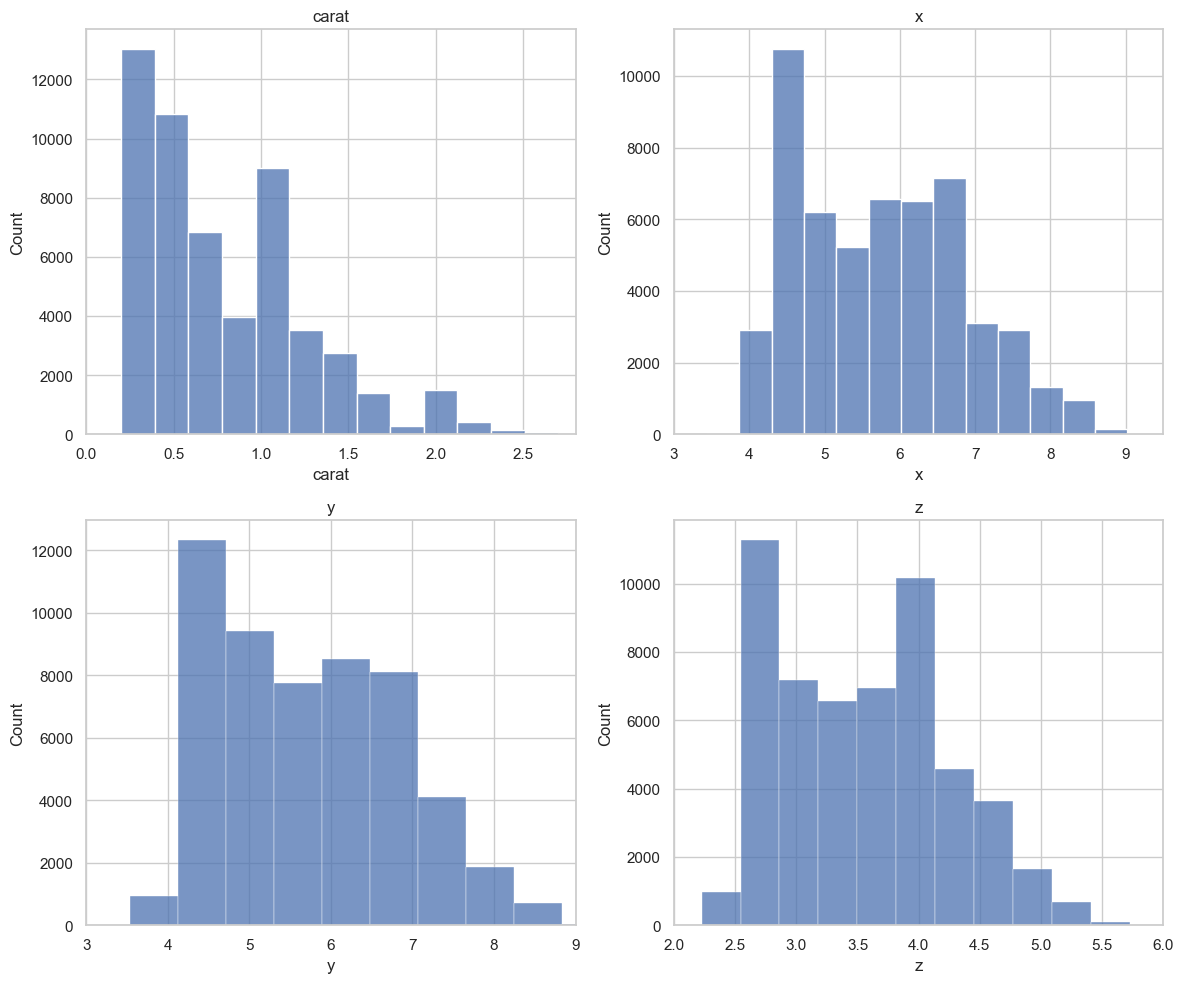

In [21]:
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# carat（
sns.histplot(data=df, x='carat', bins=25, ax=axs[0, 0])
axs[0, 0].set_title("carat")
axs[0, 0].set_xlim(0, 2.8)

# x
sns.histplot(data=df, x='x', bins=25, ax=axs[0, 1])
axs[0, 1].set_title("x")
axs[0, 1].set_xlim(3, 9.5)

# y
sns.histplot(data=df, x='y', bins=100, ax=axs[1, 0])
axs[1, 0].set_title("y")
axs[1, 0].set_xlim(3, 9)

# z
sns.histplot(data=df, x='z', bins=100, ax=axs[1, 1])
axs[1, 1].set_title("z")
axs[1, 1].set_xlim(2, 6)

plt.tight_layout()
plt.show()

In [ ]:
# KNN(K=1~30)
selected_features = ['carat', 'x', 'y', 'z']
X_train_sel = pd.DataFrame(X_train, columns=X.columns)[selected_features]
X_test_sel = pd.DataFrame(X_test, columns=X.columns)[selected_features]

rmse_list = []
r2_list = []

for k in range(1, 31):
    knn = KNeighborsRegressor(n_neighbors=k, weights='uniform', metric='minkowski')
    knn.fit(X_train_sel, y_train)
    y_pred = knn.predict(X_test_sel)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    rmse_list.append(rmse)
    r2_list.append(r2)

knn_df = pd.DataFrame({
    'k': range(1, 31),
    'RMSE': rmse_list,
    'R²': r2_list
})

knn_df.head(15)

,k,RMSE,R²
0,1,1287.632419,0.891222
1,2,1131.287504,0.916034
2,3,1078.388610,0.923703
3,4,1047.003890,0.928080
4,5,1029.347280,0.930485
5,6,1022.208706,0.931446
6,7,1010.699664,0.932981
7,8,1005.370024,0.933686
8,9,999.773503,0.934422
9,10,996.623793,0.934834


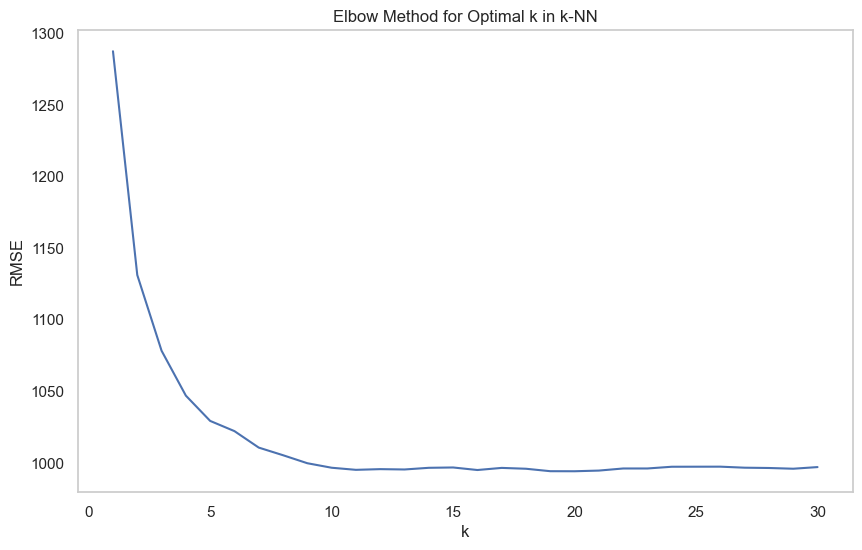

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), rmse_list)
plt.title('Elbow Method for Optimal k in k-NN')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.grid()
plt.show()

In [24]:
# Lasso
X_train_sel = X_train
X_test_sel = X_test

param_grid = {'alpha': [5, 10, 20, 30, 40, 45, 50, 55, 100]}

lasso = Lasso(max_iter=10000)
grid = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=10)
grid.fit(X_train, y_train)

# 評估每一組 alpha 的 RMSE & R²
results = []
for alpha in param_grid['alpha']:
    model = Lasso(alpha=alpha, max_iter=10000)
    model.fit(X_train_sel, y_train)
    y_pred = model.predict(X_test_sel)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append({'alpha': alpha, 'RMSE': rmse, 'R2_Score': r2})

table_df = pd.DataFrame(results)
table_df['RMSE'] = table_df['RMSE'].apply(lambda x: f"{x:.2f}")
table_df['R2_Score'] = table_df['R2_Score'].apply(lambda x: f"{x:.4f}")

table_df

,alpha,RMSE,R2_Score
0,5,1313.99,0.8867
1,10,1317.79,0.8861
2,20,1330.06,0.8839
3,30,1347.07,0.8809
4,40,1349.53,0.8805
5,45,1350.99,0.8803
6,50,1352.59,0.8800
7,55,1354.35,0.8797
8,100,1376.05,0.8758


In [25]:
knn_row = knn_df[knn_df['k'] == 11].iloc[0]
knn_rmse = knn_row['RMSE']
knn_r2 = knn_row['R²']

lasso_row = table_df[table_df['alpha'] == 5].iloc[0]
lasso_rmse = float(lasso_row['RMSE'])
lasso_r2 = float(lasso_row['R2_Score'])

summary_table = pd.DataFrame({
    'Model': ['k-NN', 'LASSO'],
    'Parameter': ['k = 11', 'alpha = 5'],
    'RMSE': [f"{knn_rmse:.2f}", f"{lasso_rmse:.2f}"],
    'R²': [f"{knn_r2:.4f}", f"{lasso_r2:.4f}"]
})

summary_table


,Model,Parameter,RMSE,R²
0,k-NN,k = 11,995.16,0.9350
1,LASSO,alpha = 5,1313.99,0.8867


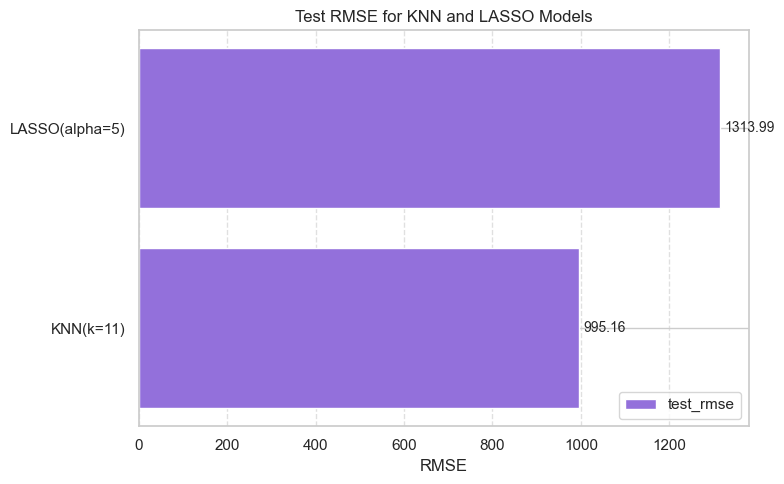

In [26]:
knn_rmse_k11 = knn_df.loc[knn_df['k'] == 11, 'RMSE'].values[0]
lasso_rmse_a5 = float(table_df.loc[table_df['alpha'] == 5, 'RMSE'].values[0])

compare_df = pd.DataFrame({
    'model': ['KNN(k=11)', 'LASSO(alpha=5)'],
    'test_rmse': [knn_rmse_k11, lasso_rmse_a5]
})

plt.figure(figsize=(8, 5))
bars = plt.barh(compare_df['model'], compare_df['test_rmse'], color='mediumpurple', label='test_rmse')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 10, bar.get_y() + bar.get_height()/2,
             f"{width:.2f}", va='center', fontsize=10)

plt.xlabel('RMSE')
plt.title('Test RMSE for KNN and LASSO Models')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()